In [1]:
#hide
# Import time!
from icecream import ic
from loguru import logger
from rich.logging import RichHandler

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=130)

from fastai.imports import *
from fastai.collab import *
from fastai.tabular.all import *

# Logging setup
logger.configure(
    handlers=[
        {
            "sink": RichHandler(
                log_time_format="%Y-%m-%d %X",
                rich_tracebacks=True,
                show_path=False,
                tracebacks_width=200,
            ),
            "format": "{message}",
            "level": "DEBUG",
        }
    ]
)

[1]

In [2]:
ml_data = untar_data(URLs.ML_100k)

In [3]:
ml_data

Path('/Users/karl/.fastai/data/ml-100k')

In [4]:
ratings_df = pd.read_csv(ml_data / 'u.data', delimiter='\t', header=None, names=['user', 'movie', 'rating', 'timestamp'])
ratings_df.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
movies_df = pd.read_csv(ml_data / 'u.item', delimiter='|', encoding='latin-1', usecols=(0, 1), names=('movie', 'title'), header=None)
movies_df.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
# Add movie names to ratings df
ratings_df = ratings_df.merge(movies_df)
ratings_df.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [7]:
# The data loader needs a 'user' and 'item' column
data_loader = CollabDataLoaders.from_df(ratings_df, item_name='title', bs=64)
data_loader.show_batch()

,user,title,rating
0,244,Young Frankenstein (1974),5
1,280,Carlito's Way (1993),2
2,710,Bedknobs and Broomsticks (1971),3
3,668,Batman (1989),4
4,378,Muriel's Wedding (1994),4
5,933,Quiz Show (1994),3
6,506,Local Hero (1983),4
7,666,Apollo 13 (1995),3
8,169,"Peacemaker, The (1997)",5
9,92,Amadeus (1984),4


In [8]:
user_count = len(data_loader.classes['user'])
movie_count = len(data_loader.classes['title'])

factor_count = 5

user_factors = torch.randn(user_count, factor_count)
movie_factors = torch.randn(movie_count, movie_count)

To get the n-item in the list above so we can get the factors, we can do a matmul with a one-hot encoded vector!

In [9]:
one_hot_3 = one_hot(3, user_count).float()

In [10]:
user_factors.t() @ one_hot_3

tensor([ 0.9027, -0.1588, -0.1412, -0.8733, -1.3211])

In [11]:
user_factors[3]

tensor([ 0.9027, -0.1588, -0.1412, -0.8733, -1.3211])

Time to write our own collab filetering module!

In [12]:
class DotProduct(Module):
    def __init__(self, user_count, movie_count, factor_count):
        self.user_factors = Embedding(user_count, factor_count)
        self.movie_factors = Embedding(movie_count, factor_count)

    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])

        return (users * movies).sum(dim=1)

In [13]:
model = DotProduct(user_count, movie_count, factor_count)
learn = Learner(data_loader, model, loss_func=MSELossFlat())

In [14]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time


To help the model train better, we can use a sigmoid output to fix the result to (0,5).
In practice, allowing a slightly larger bound helps so we'll use (0, 5.5)

In [15]:
class DotProduct(Module):
    def __init__(self, user_count, movie_count, factor_count, y_range=(0, 5.5)):
        self.user_factors = Embedding(user_count, factor_count)
        self.movie_factors = Embedding(movie_count, factor_count)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])

        return sigmoid_range((users * movies).sum(dim=1),  *self.y_range)

Current loss after 5 epochs: 0.8966

Now, after this, it would really be better if we could add a bias term to the dot product as well

In [16]:
class DotProductBias(Module):
    def __init__(self, user_count, movie_count, factor_count, y_range=(0, 5.5)):
        self.user_factors = Embedding(user_count, factor_count)
        self.user_bias = Embedding(user_count, 1)
        self.movie_factors = Embedding(movie_count, factor_count)
        self.movie_bias = Embedding(movie_count, 1)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])

        dot_product = (
            (users * movies).sum(dim=1, keepdim=True)
            + self.user_bias(x[:, 0])
            + self.movie_bias(x[:, 1])
        )

        return sigmoid_range(dot_product,  *self.y_range)

In [17]:
model = DotProductBias(user_count, movie_count, factor_count)
learn = Learner(data_loader, model, loss_func=MSELossFlat())

In [18]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.962281,0.933434,00:06
1,0.867775,0.861739,00:06
2,0.828343,0.830607,00:06
3,0.732695,0.819922,00:06
4,0.753097,0.819800,00:06


Loss after 5 epochs with bias: 0.8473

With this, however, we're right on the edge of overfitting, so we best look at techniques like weight decay (also called L2 regularisation).
So, to the loss function, we add sum(weights**2)

Let's show this with an example...

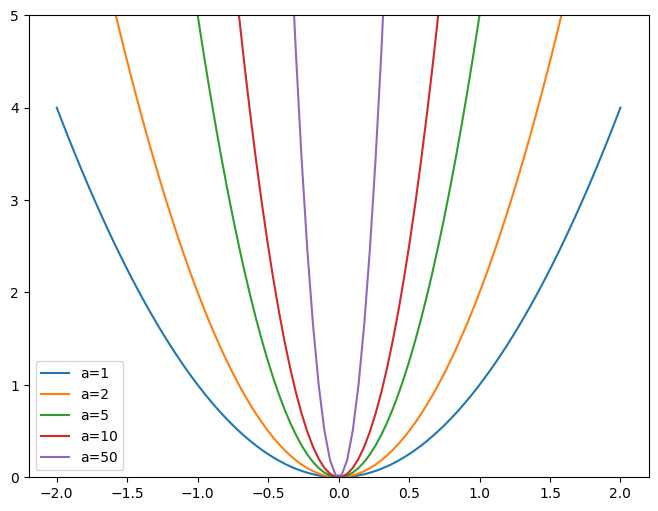

In [19]:
x = np.linspace(-2, 2, 100)
a_s = [1, 2, 5, 10, 50]
ys = [a * x**2 for a in a_s]
_, ax = plt.subplots(figsize=(8, 6))
for a, y in zip(a_s, ys):
    ax.plot(x, y, label=f'a={a}')
ax.set_ylim(0, 5)
ax.legend()

In [20]:
model = DotProductBias(user_count, movie_count, 50)
learn = Learner(data_loader, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time


Loss after 5 epochs with weight decay and 50 params: 0.8473 -> 0.8255. That's not bad consdiering we added  way more variables!

To go any further, it's best to create our own embedding module to see how things work under the hood.

## Create Our Own Embedding Module

In [21]:
class T(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [22]:
nn.Parameter??

Init signature: nn.Parameter(data=None, requires_grad=True)
Source:        
class Parameter(torch.Tensor, metaclass=_ParameterMeta):
    r"""A kind of Tensor that is to be considered a module parameter.

    Parameters are :class:`~torch.Tensor` subclasses, that have a
    very special property when used with :class:`Module` s - when they're
    assigned as Module attributes they are automatically added to the list of
    its parameters, and will appear e.g. in :meth:`~Module.parameters` iterator.
    Assigning a Tensor doesn't have such effect. This is because one might
    want to cache some temporary state, like last hidden state of the RNN, in
    the model. If there was no such class as :class:`Parameter`, these
    temporaries would get registered too.

    Args:
        data (Tensor): parameter tensor.
        requires_grad (bool, optional): if the parameter requires gradient. Note that
            the torch.no_grad() context does NOT affect the default behavior of
            P

In [23]:
class T(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [24]:
class T(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[ 0.3674],
        [ 0.6670],
        [-0.1208]], requires_grad=True)]

In [25]:
type(t.a.weight)

torch.nn.parameter.Parameter

So, if you create `nn.Parameter` in `__init__` (or a subclass of it, like `nn.Linear`), the `Module` class automatically knows about it and uses it when trying to deduce what parameters it contains

In [26]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [29]:
class DotProductBias(nn.Module):
    def __init__(self, user_count, movie_count, factor_count, y_range=(0, 5.5)):
        super().__init__()
        self.user_factors = create_params([user_count, factor_count])
        self.user_bias = create_params([user_count, 1])
        self.movie_factors = create_params([movie_count, factor_count])
        self.movie_bias = create_params([movie_count, 1])
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors[x[:, 0]]
        movies = self.movie_factors[x[:, 1]]

        dot_product = (
            (users * movies).sum(dim=1, keepdim=True)
            + self.user_bias[x[:, 0]]
            + self.movie_bias[x[:, 1]]
        )

        return sigmoid_range(dot_product,  *self.y_range)


In [30]:

ic(user_count)
ic(movie_count)

model = DotProductBias(user_count, movie_count, 50)
learn = Learner(data_loader, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

ic| user_count: 944
ic| movie_count: 1665


epoch,train_loss,valid_loss,time
0,0.954838,0.929551,00:05
1,0.863852,0.857679,00:05
2,0.722450,0.819254,00:05
3,0.592296,0.807754,00:05
4,0.475209,0.808507,00:05


# Interpreting Embeddings and Biases (which movies?)

In [31]:
movie_bias = learn.model.movie_bias.squeeze()

lowest_movie_bias_idxs = movie_bias.argsort()[:5]
[data_loader.classes['title'][idx] for idx in lowest_movie_bias_idxs]

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Cable Guy, The (1996)',
 'Showgirls (1995)',
 'Barb Wire (1996)',
 'Hellraiser: Bloodline (1996)']

In [32]:
highest_movie_bias_idxs = movie_bias.argsort(descending=True)[:5]
[data_loader.classes['title'][idx] for idx in highest_movie_bias_idxs]

["Schindler's List (1993)",
 'Titanic (1997)',
 'Silence of the Lambs, The (1991)',
 'Star Wars (1977)',
 'Good Will Hunting (1997)']

Now, do some PCA to try and find the right space which defines these movies

In [35]:
g = ratings_df.groupby('title')['rating'].count()
g

# This is the list of how many times a movie has been seen

title
'Til There Was You (1997)                  9
1-900 (1994)                               5
101 Dalmatians (1996)                    109
12 Angry Men (1957)                      125
187 (1997)                                41
                                        ... 
Young Guns II (1990)                      44
Young Poisoner's Handbook, The (1995)     41
Zeus and Roxanne (1997)                    6
unknown                                    9
Á köldum klaka (Cold Fever) (1994)         1
Name: rating, Length: 1664, dtype: int64

In [37]:
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)', 'Raiders of the Lost Ark (1981)', 'Godfather, The (1972)', 'Pulp Fiction (1994)',
       'Twelve Monkeys (1995)', 'Silence of the Lambs, The (1991)', 'Jerry Maguire (1996)', 'Chasing Amy (1997)',
       'Rock, The (1996)', 'Empire Strikes Back, The (1980)', 'Star Trek: First Contact (1996)', 'Titanic (1997)',
       'Back to the Future (1985)', 'Mission: Impossible (1996)', 'Fugitive, The (1993)',
       'Indiana Jones and the Last Crusade (1989)', 'Willy Wonka and the Chocolate Factory (1971)', 'Princess Bride, The (1987)',
       'Forrest Gump (1994)', 'Saint, The (1997)', 'Monty Python and the Holy Grail (1974)', 'Full Monty, The (1997)',
       'Men in Black (1997)', 'Terminator, The (1984)', 'E.T. the Extra-Terrestrial (1982)', 'Dead Ma

In [38]:
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
top_idxs

tensor([1399,  334,  499, 1235,  861,  461, 1285, 1524,   33,  745, 1206,  613,
        1191, 1544, 1330,  781,  294, 1252,  457, 1395, 1501,  114,  988,  571,
         748, 1634, 1179,  552, 1275,  997,  573,  965, 1462,  447,  390,  856,
        1282,  226,  830,  333, 1461,  179, 1548, 1006,   42, 1616,   45, 1318,
         774,  644,   89,   51,  185, 1538, 1298, 1211, 1573, 1103,  798,  477,
           8, 1209,  374,  236,  391,  200,  555,  580, 1525,  529, 1645, 1398,
        1147,  274,  415, 1408,  412,  379,  628, 1190, 1302, 1496,  763,  734,
        1374,  716, 1387,  624,  667, 1366,  318,  346,   88, 1517,  868,   37,
         110, 1589, 1508, 1021,  946,  250, 1136, 1340,  518, 1402,  592,  614,
        1216, 1534,  227,  910,  464, 1323,  143,  210,  133, 1658, 1392,  622,
         304,  520,  581,  434,  485, 1498, 1014, 1482, 1271,  208,  411,  884,
         885, 1557,  977, 1168, 1566, 1457,  381,  539, 1516,   83, 1078, 1581,
         313, 1177,  948,  456, 1468, 10

In [39]:
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
movie_pca

# This is the representation of each movie along 3 as-distinct-as-possible axes

tensor([[-0.7377, -0.7802,  0.5074],
        [ 0.0747, -0.4222,  0.1323],
        [-0.8257,  0.2175, -0.0692],
        ...,
        [-0.0475,  0.0874, -0.0421],
        [ 0.9300, -0.0956, -0.2002],
        [ 0.2116,  0.5467, -0.0072]])

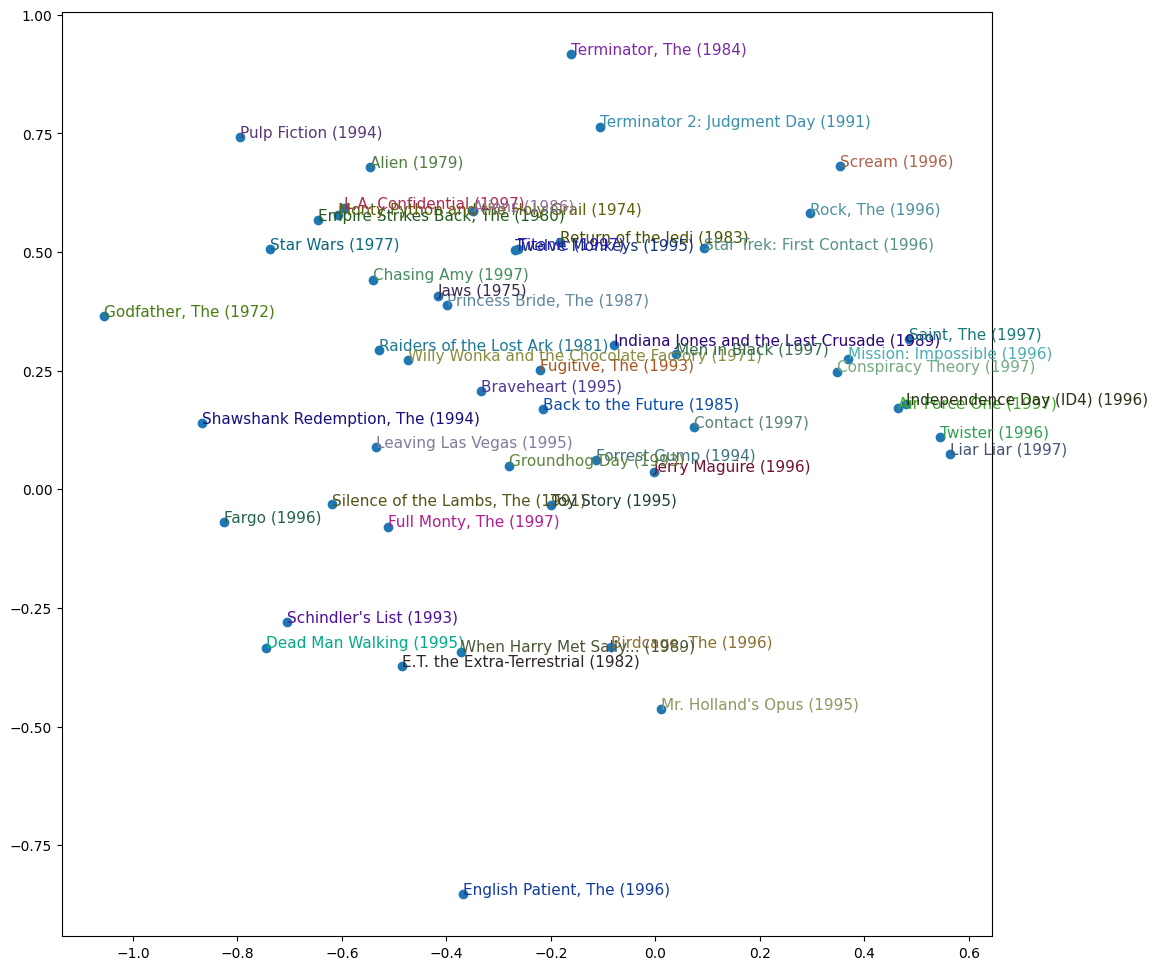

In [42]:
# Get points for top 50 movies and scatter plot them

factor_0, factor_1, factor_2 = movie_pca.t()
idxs = list(range(50))

X = factor_0[idxs]
Y = factor_2[idxs]

plt.figure(figsize=(12, 12))
plt.scatter(X, Y)

for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)

plt.show()